## Logistic Regression with SGD

To begin you first need to install all dependencies, using:

    pip install -r requirements.txt

In [639]:
import numpy as np
import matplotlib.pyplot as plt

from math import exp, log
import os
import pickle

from skimage import io
from skimage.color import rgb2gray
from skimage.feature import hog

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression as LRM


In [3]:
%matplotlib inline

### load the dataset

In [4]:
### set your image dir here
IMAGE_DIR = "./all/"

In [5]:
def load_dataset(subset="train"):
    """
    1. subset = "train", "val", "test"
    2. About the dataset: in "train","val" subset, the first half of images are images of hands, the rest half are images of not-hand. 
    3. extract features from HoG
    """
    path = os.path.join(IMAGE_DIR,subset)
    name_list = os.listdir(path)
    print("Number of images in {}-set: {}".format(subset, len(name_list)))
    #HoG returns 324 features
    X = np.zeros(shape=(len(name_list), 324))

    if subset == "train" or subset == "val":
        #Make sure that we have equal number of positive and negative class images
        assert len(name_list)%2 == 0
        count = len(name_list)//2
        y = np.array(count*[1] + count*[0])
        for idx_true in range(count):
            img_name = os.path.join(path,str(idx_true)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx_true, :] = vec
        
        for idx in range(count):
            idx_false = idx + count
            img_name = os.path.join(path,str(idx_false)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx_false, :] = vec
        return X, y        
    else:
        for idx in range(len(name_list)):
            img_name = os.path.join(path, str(idx)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx, :] = vec
        return X

### load the data

In [6]:
X_train, y_train = load_dataset("train")
X_val, y_val = load_dataset("val")
X_test = load_dataset("test")

Number of images in train-set: 8170


/usr/local/lib/python2.7/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


Number of images in val-set: 2724
Number of images in test-set: 5542


### displaying images

In [7]:
def display(img_path):
    """
    visualize the img
    """
    img = io.imread(img_path)
    print(img_path)
    io.imshow(img)
    io.show()

./all/train/1.png


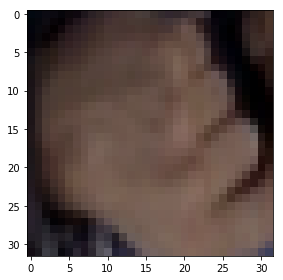

In [8]:
display(IMAGE_DIR+"train/1.png")

### Logistic regression

#### Main function in the class
1. \__init\__() which sets the hyper parameters
2. sigmoid()
3. __init_param(), initializes the parameters .
4. fit(): train the data
5. predict_proba(): predict the probability of the sample belonging to the positive class
6. predict(): classify the sample


Feel free to overlook the rest of the parts of the code, it's just for convenience.


In [621]:
class LogisticRegression:
    """
    Logistic Regression
    """
    def __init__(self, eta0=0.1, eta1=1, m=16, max_epoch=1000, delta=0.0001):
        """
        m is the batch_size
        """
        self.__init = True # whether to initial the parameters
        self.__eta0 = eta0
        self.__eta1 = eta1
        self.__delta = delta
        self.__m = m
        self.__max_epoch = max_epoch
        
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))
    
    def __init_param(self):
        """
        Weights initialized using a normal distribution here: you can change the distribution.
        """
        d = self.__dimension
        self.__wt = np.random.randn(1,d)
        self.__bias = np.random.randn(1,1)
        return self.__wt,self.__bias
    
    def loss(self,theta, X, y):
        h = self.sigmoid(X.dot(theta))
        first = np.dot(-y.T, np.log(h) )
        second = np.dot((1 - y).T, np.log(1 - h ) )
#         return np.mean(first-second)
        return np.sum(first - second) / (len(X))
#         return ((-y * np.log(h)) - ((1 - y) * np.log(1 - h) )).mean()
    
    
    def add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((X, intercept), axis=1)
    
    def fit_w_intercept(self, X, y, X_val=None, y_val=None):
        n, d = X.shape
        self.__dimension = d
        if self.__init:
            self.__init_param()
        ### write your code here ### 
        
        batch_size = 16
        delta = self.__delta
        X = np.asmatrix(X)
        y = np.asmatrix(y).T
        theta_old = []
        theta_new = (self.__wt).T
        loss = []
        validation_loss = []
        for epoch in range(1,self.__max_epoch+1):
            eta = (self.__eta0 / (self.__eta1 + epoch))
            X,y = shuffle(X,y)
            theta_old = np.copy(theta_new)
            for start in xrange(0,len(X), batch_size):
                batchx = np.asmatrix(X[start:start+batch_size])
                batchy = np.asmatrix(y[start:start+batch_size])
                z = np.dot(batchx, theta_new)
                h = self.sigmoid(z)
                gradient = np.dot((h - batchy).T, batchx) / len(batchy)
                theta_new = np.subtract(theta_new , (eta*gradient.T))
            
            new_loss = self.loss(theta_new, X, y)
            loss.append(new_loss)
            old_loss = self.loss(theta_old, X, y)
            self.__wt = theta_new.T
            v_new_loss = self.loss(theta_new, X_val, y_val)
            validation_loss.append(v_new_loss)
            if(epoch % 100 == 0):
                print(epoch, "Training Loss:", new_loss, "Validation Accuracy:", accuracy_score(y_val, self.predict(X_val)), "Validation Loss:",v_new_loss)
        self.__wt = theta_new.T
        return theta_new, loss, validation_loss

    def fit(self, X, y, kaggle=False, logging=False, X_val=None, y_val=None):
        """
        Recommended input:
        X: n x d array,
        y: n x 1 array or list
        """
        n, d = X.shape
        self.__dimension = d
        if self.__init:
            self.__init_param()
        ### write your code here ### 
        batch_size = 16
        delta = self.__delta
        X_train = self.add_intercept(X)
        X_train = np.asmatrix(X_train)
        y_train = np.asmatrix(y).T
        theta_old = []
        theta_new = np.concatenate((self.__wt, self.__bias),axis=1).T
        loss = []
        validation_loss = []
        training_accuracy = []
        validation_accuracy = []
        for epoch in range(1,self.__max_epoch+1):
            eta = (self.__eta0 / (self.__eta1 + epoch))
            X_train,y_train = shuffle(X_train, y_train)
            theta_old = np.copy(theta_new)
            for start in xrange(0,len(X_train), batch_size):
                batchx = np.asmatrix(X_train[start:start+batch_size])
                batchy = np.asmatrix(y_train[start:start+batch_size])
                z = np.dot(batchx, theta_new)
                h = self.sigmoid(z)
                gradient = np.dot((h - batchy).T, batchx) / len(batchy)
                theta_new = np.subtract(theta_new , (eta*gradient.T))
            
            new_loss = self.loss(theta_new, X_train, y_train)
            loss.append(new_loss)
            
            old_loss = (1-delta)*self.loss(theta_old, X_train, y_train)
            
            self.__wt = theta_new[:-1].T
            self.__bias = theta_new[-1:]
            
            v_new_loss = self.loss(theta_new, self.add_intercept(X_val), y_val)
            validation_loss.append(v_new_loss)
            
            v_accuracy = accuracy_score(y_val, self.predict(X_val))
            validation_accuracy.append(v_accuracy)
            
            t_accuracy = accuracy_score(y, self.predict(X))
            training_accuracy.append(t_accuracy)
            
            if(logging and epoch % 100 == 0):
                print(epoch, "Training Loss:", new_loss, "Training Accuracy", t_accuracy, "Validation Accuracy:", v_accuracy, "Validation Loss:",v_new_loss)
            
            if (not kaggle and new_loss > old_loss) :
                theta_new = np.copy(theta_old)
                print(epoch, "Training Loss:", new_loss, "Training Accuracy", t_accuracy, "Validation Accuracy:", v_accuracy, "Validation Loss:",v_new_loss)
                break
        
        self.__wt = theta_new[:-1].T
        self.__bias = np.asmatrix(theta_new[-1:])
        return theta_new, loss, validation_loss , training_accuracy , validation_accuracy
        
        ############################
        
    def w_predict_probs(self, X):
        """
        predict the probility of the sample
        You can refer to my code below
        """
        theta = self.__wt.T
        return self.sigmoid(np.dot((X), theta))
#         return a vector containing the probability values of the samples belonging to the positive class
    
    def w_predict(self, X):
        """
        Classify the sample
        """
        threshhold = 0.5
        return self.w_predict_probs(X) >= threshhold
#         return self.predict_proba(X) >= 0.5 # attention: this will give result in bool, you need to convert it to int for submission.
    
    def predict_probs(self, X):
        """
        predict the probility of the sample
        You can refer to my code below
        """
        theta = np.concatenate((self.__wt, self.__bias),axis=1).T
        return self.sigmoid(np.dot(self.add_intercept(X), theta))
#         return a vector containing the probability values of the samples belonging to the positive class
    
    def predict(self, X):
        """
        Classify the sample
        """
        threshhold = 0.5
        return self.predict_probs(X) >= threshhold
#         return self.predict_proba(X) >= 0.5 # attention: this will give result in bool, you need to convert it to int for submission. 

    def get_param(self):
        """
        output:
            parameters: wt(1*d array), b(scalar)
        """
        return [self.__wt, self.__bias]
    
    def save_model(self, save_file):
        """
        save model to .pkl file
        """
        with open(save_file,"wb") as file:
            pickle.dump([self.__wt, self.__bias],file)

    def load_model(self, load_file):
        """
        load model from .pkl file
        """
        with open(load_file,"rb") as file:
            param = pickle.load(file)
        self.__wt = param[0]
        self.__bias = param[1]
        self.__init = False
        return self.__wt, self.__bias

## Question 2.3

### 1. Baseline Model

(100, 'Training Loss:', 0.5301858335217645, 'Training Accuracy', 0.8050183598531212, 'Validation Accuracy:', 0.8043318649045521, 'Validation Loss:', 0.529705766330365)
(200, 'Training Loss:', 0.5167790945638789, 'Training Accuracy', 0.8115055079559363, 'Validation Accuracy:', 0.8098384728340675, 'Validation Loss:', 0.5161176388975615)
(300, 'Training Loss:', 0.5096604385715988, 'Training Accuracy', 0.815422276621787, 'Validation Accuracy:', 0.8124082232011748, 'Validation Loss:', 0.5089042866996009)
(330, 'Training Loss:', 0.5080568836862912, 'Training Accuracy', 0.8160342717258262, 'Validation Accuracy:', 0.8120411160058737, 'Validation Loss:', 0.5072795503034586)
('Number of epochs till termination: ', 330)


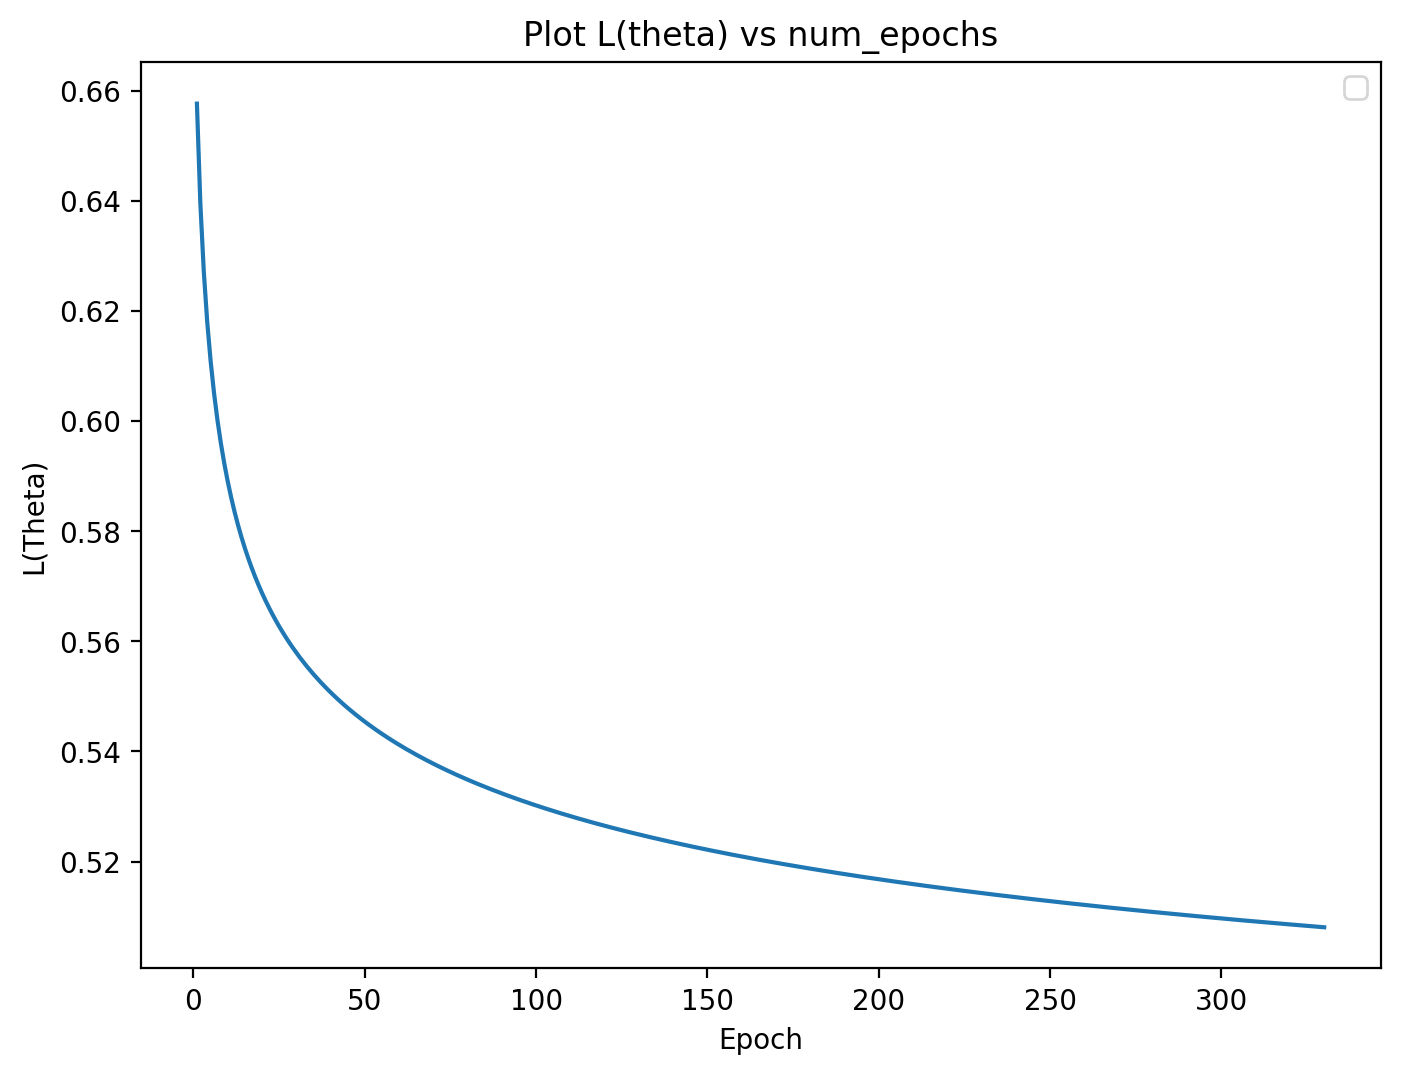

0.8120411160058737

In [552]:
LR = LogisticRegression()
theta, loss, validation_loss , training_accuracy , validation_accuracy = LR.fit(X_train,y_train, False, True, X_val, y_val)
print("Number of epochs till termination: ", len(loss))
epoch = np.arange(1,len(loss)+1,1)
plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
plt.plot(epoch, loss)
plt.xlabel('Epoch')
plt.ylabel('L(Theta)')
plt.title("Plot L(theta) vs num_epochs")
plt.legend()
plt.show()

accuracy_score(y_val, LR.predict(X_val))


### (a) Number of epochs till termination = 330

In [290]:
# (b) Plot L(theta) vs num_epochs

(c) Final value of L($\theta$) after optimization = 0.5080568836862912

### 2. Experimenting with ($\eta_0$,$\eta_1$)

In [557]:
# Experimentation code goes here

eta = 0.001
eta1 = 0.001
best_acc = 0.0
while (eta<= 100):
    while(eta1 <= 100):
        print(eta, eta1)
        LR = LogisticRegression(eta,eta1,16,1000, 0.0001)
        theta, loss, validation_loss , training_accuracy , validation_accuracy = LR.fit(X_train,y_train, False, False, X_val, y_val)
        temp = accuracy_score(y_val, LR.predict(X_val))
        if temp > best_acc:
            best_acc = temp
        eta1 = eta1*10
    eta1 = 0.001
    eta = eta*10
print(best_acc)


(0.001, 0.001)
(22, 'Training Loss:', 0.6721943374138256, 'Training Accuracy', 0.5649938800489596, 'Validation Accuracy:', 0.5638766519823789, 'Validation Loss:', 0.6752031235656198)
(0.001, 0.01)
(34, 'Training Loss:', 0.6975981724748747, 'Training Accuracy', 0.5189718482252142, 'Validation Accuracy:', 0.5216593245227606, 'Validation Loss:', 0.696332876145279)
(0.001, 0.1)
(196, 'Training Loss:', 0.7798406149993219, 'Training Accuracy', 0.4944920440636475, 'Validation Accuracy:', 0.5, 'Validation Loss:', 0.7738070001854401)
(0.001, 1.0)
(80, 'Training Loss:', 0.7339902115726263, 'Training Accuracy', 0.47319461444308447, 'Validation Accuracy:', 0.4812775330396476, 'Validation Loss:', 0.7323002118373625)
(0.001, 10.0)
(75, 'Training Loss:', 0.7165778184849518, 'Training Accuracy', 0.5260709914320686, 'Validation Accuracy:', 0.5183553597650514, 'Validation Loss:', 0.7208217106597764)
(0.001, 100.0)
(624, 'Training Loss:', 1.4582295356102244, 'Training Accuracy', 0.5, 'Validation Accuracy

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


(6, 'Training Loss:', 0.5459707680159734, 'Training Accuracy', 0.8572827417380661, 'Validation Accuracy:', 0.841042584434655, 'Validation Loss:', 0.6126647316477551)
(100.0, 0.01)
(7, 'Training Loss:', 0.3786432449727296, 'Training Accuracy', 0.8877600979192166, 'Validation Accuracy:', 0.8715124816446402, 'Validation Loss:', 0.42698423340968517)
(100.0, 0.1)
(1, 'Training Loss:', 1.7975315258558673, 'Training Accuracy', 0.7627906976744186, 'Validation Accuracy:', 0.7562408223201175, 'Validation Loss:', 1.9033160189148348)
(100.0, 1.0)
(4, 'Training Loss:', 0.4562688596947015, 'Training Accuracy', 0.8373317013463892, 'Validation Accuracy:', 0.828928046989721, 'Validation Loss:', 0.49709516148410293)
(100.0, 10.0)
(5, 'Training Loss:', 0.3009226984051513, 'Training Accuracy', 0.8730722154222766, 'Validation Accuracy:', 0.8619676945668135, 'Validation Loss:', 0.31377766194551)
(100.0, 100.0)
(10, 'Training Loss:', 0.3143409093991088, 'Training Accuracy', 0.8641370869033048, 'Validation Ac

(a) Best value for, $\eta_0$ = \1, $\eta_1$ = \0.001

Number of epochs for training = _253_

Final value of L($\theta$) = _0.3225782506956712_

(100, 'Training Loss:', 0.3320817001594309, 'Training Accuracy', 0.8736842105263158, 'Validation Accuracy:', 0.8718795888399412, 'Validation Loss:', 0.33048104963948605)
(200, 'Training Loss:', 0.3253548164685289, 'Training Accuracy', 0.8755201958384333, 'Validation Accuracy:', 0.8737151248164464, 'Validation Loss:', 0.32396988991385123)
(259, 'Training Loss:', 0.3231311533959868, 'Training Accuracy', 0.8767441860465116, 'Validation Accuracy:', 0.8737151248164464, 'Validation Loss:', 0.32182177545597346)
('Number of epochs till termination: ', 259)


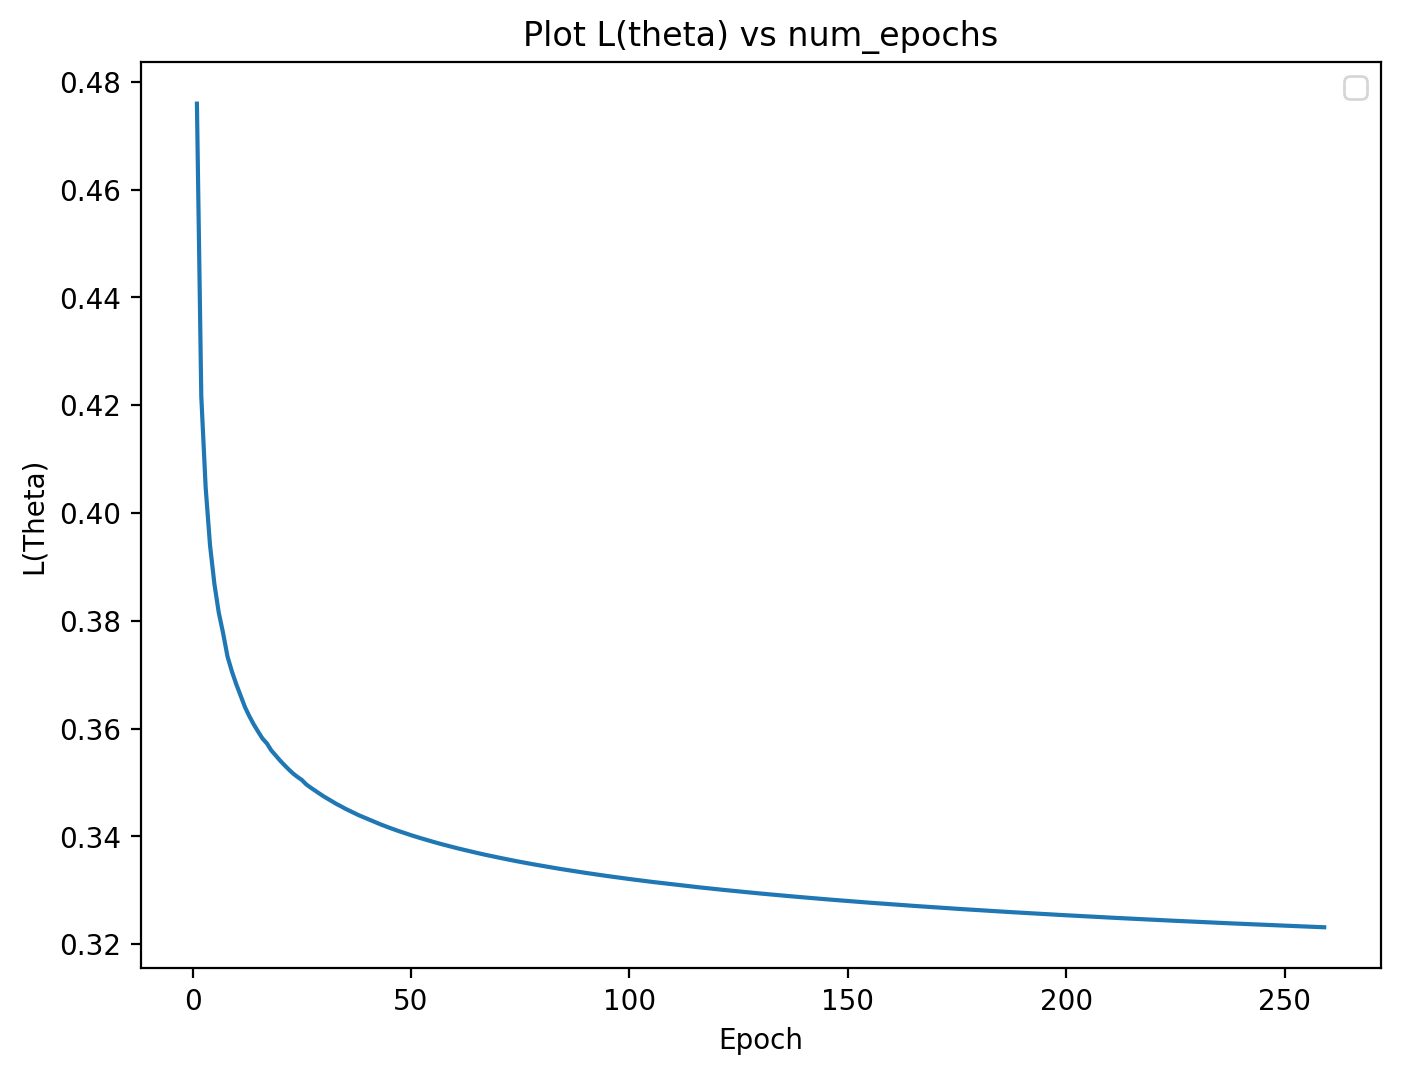

0.8733480176211453

In [663]:
# (b) For best (eta_0, eta_1) plot L(theta) vs num_epochs

eta = 1.0
eta1 = 0.001
LR = LogisticRegression(eta,eta1,16,1000, 0.0001)
theta, loss, validation_loss , training_accuracy , validation_accuracy = LR.fit(X_train,y_train, False, True, X_val, y_val)
print("Number of epochs till termination: ", len(loss))
epoch = np.arange(1,len(loss)+1,1)
plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
plt.plot(epoch, loss)
plt.xlabel('Epoch')
plt.ylabel('L(Theta)')
plt.title("Plot L(theta) vs num_epochs")
plt.legend()
plt.show()

accuracy_score(y_val, LR.predict(X_val))

### 3. Evaluating on validation set

(100, 'Training Loss:', 0.5450087711049049, 'Training Accuracy', 0.7793145654834761, 'Validation Accuracy:', 0.7966226138032305, 'Validation Loss:', 0.5406081405836195)
(200, 'Training Loss:', 0.5312127782956394, 'Training Accuracy', 0.7891064871481028, 'Validation Accuracy:', 0.8094713656387665, 'Validation Loss:', 0.526833557694475)
(300, 'Training Loss:', 0.5238176752180619, 'Training Accuracy', 0.7957160342717259, 'Validation Accuracy:', 0.8120411160058737, 'Validation Loss:', 0.5194480848944077)
(334, 'Training Loss:', 0.5219361674925856, 'Training Accuracy', 0.7973072215422277, 'Validation Accuracy:', 0.8131424375917768, 'Validation Loss:', 0.5175687484488317)
('Number of epochs till termination: ', 334)


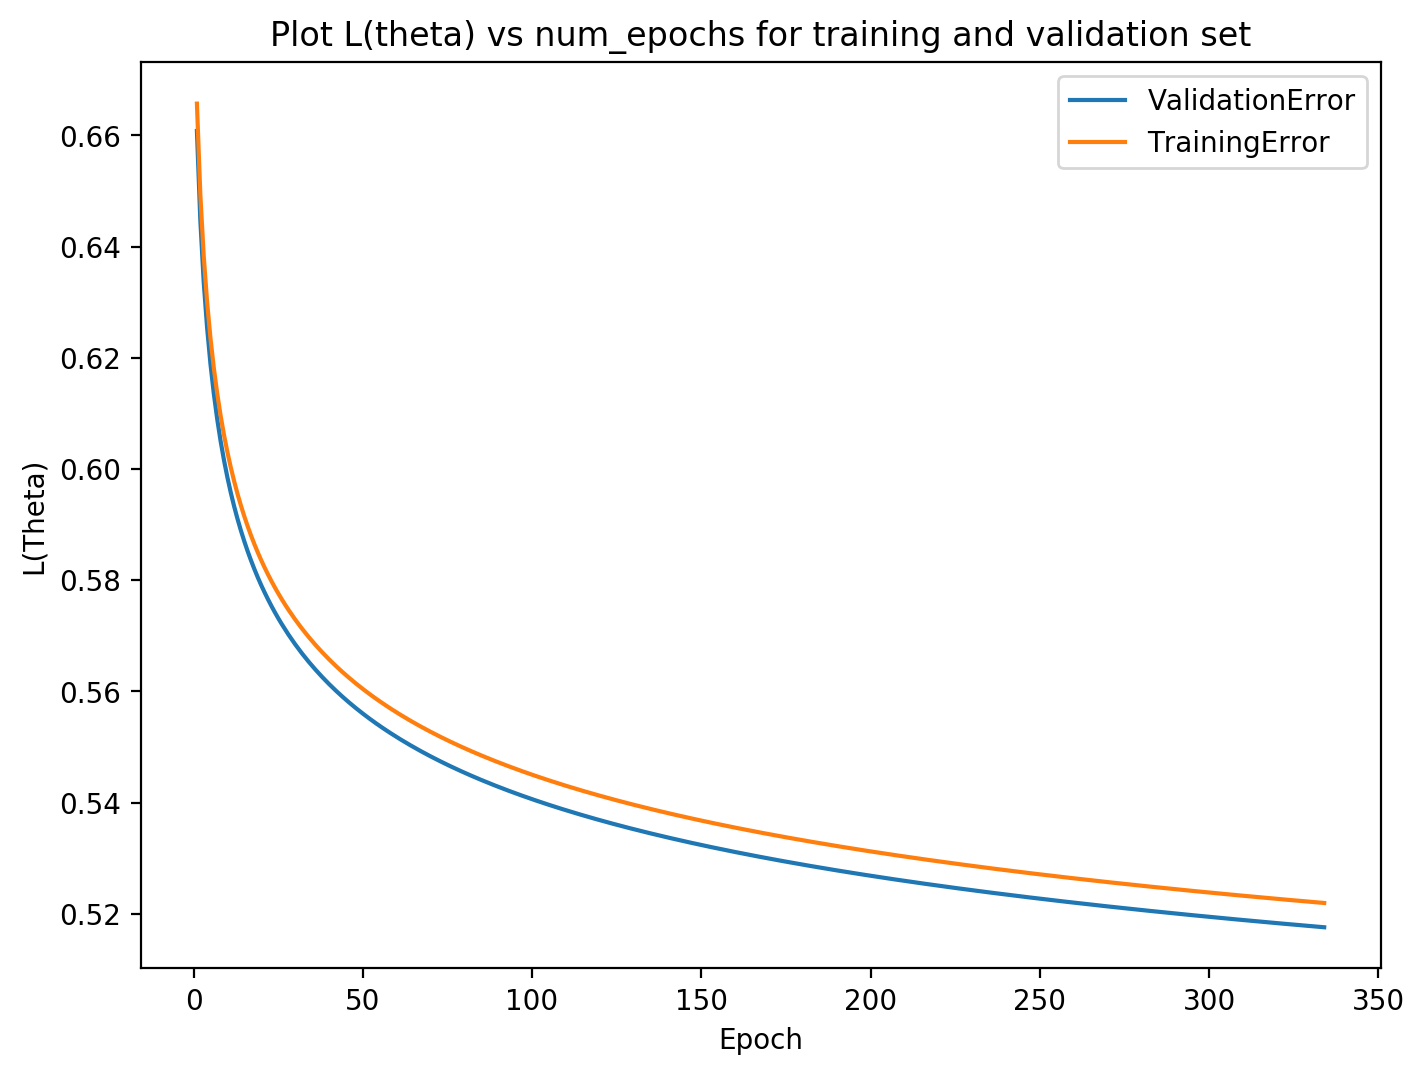

In [675]:
# (a) Plot L(theta) vs num_epochs for both training and validation set on the same figure

eta = 0.1
eta1 = 1.0
LR = LogisticRegression(eta,eta1,16,1000, 0.0001)
theta, loss, validation_loss , training_accuracy , validation_accuracy = LR.fit(X_train,y_train, False, True, X_val, y_val)
print("Number of epochs till termination: ", len(loss))
epoch = np.arange(1,len(loss)+1,1)
plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
plt.plot(epoch, validation_loss, label = "ValidationError")
plt.plot(epoch, loss, label = "TrainingError")
plt.xlabel('Epoch')
plt.ylabel('L(Theta)')
plt.title("Plot L(theta) vs num_epochs for training and validation set")
plt.legend()
plt.show()

# accuracy_score(y_val, LR.predict(X_val))


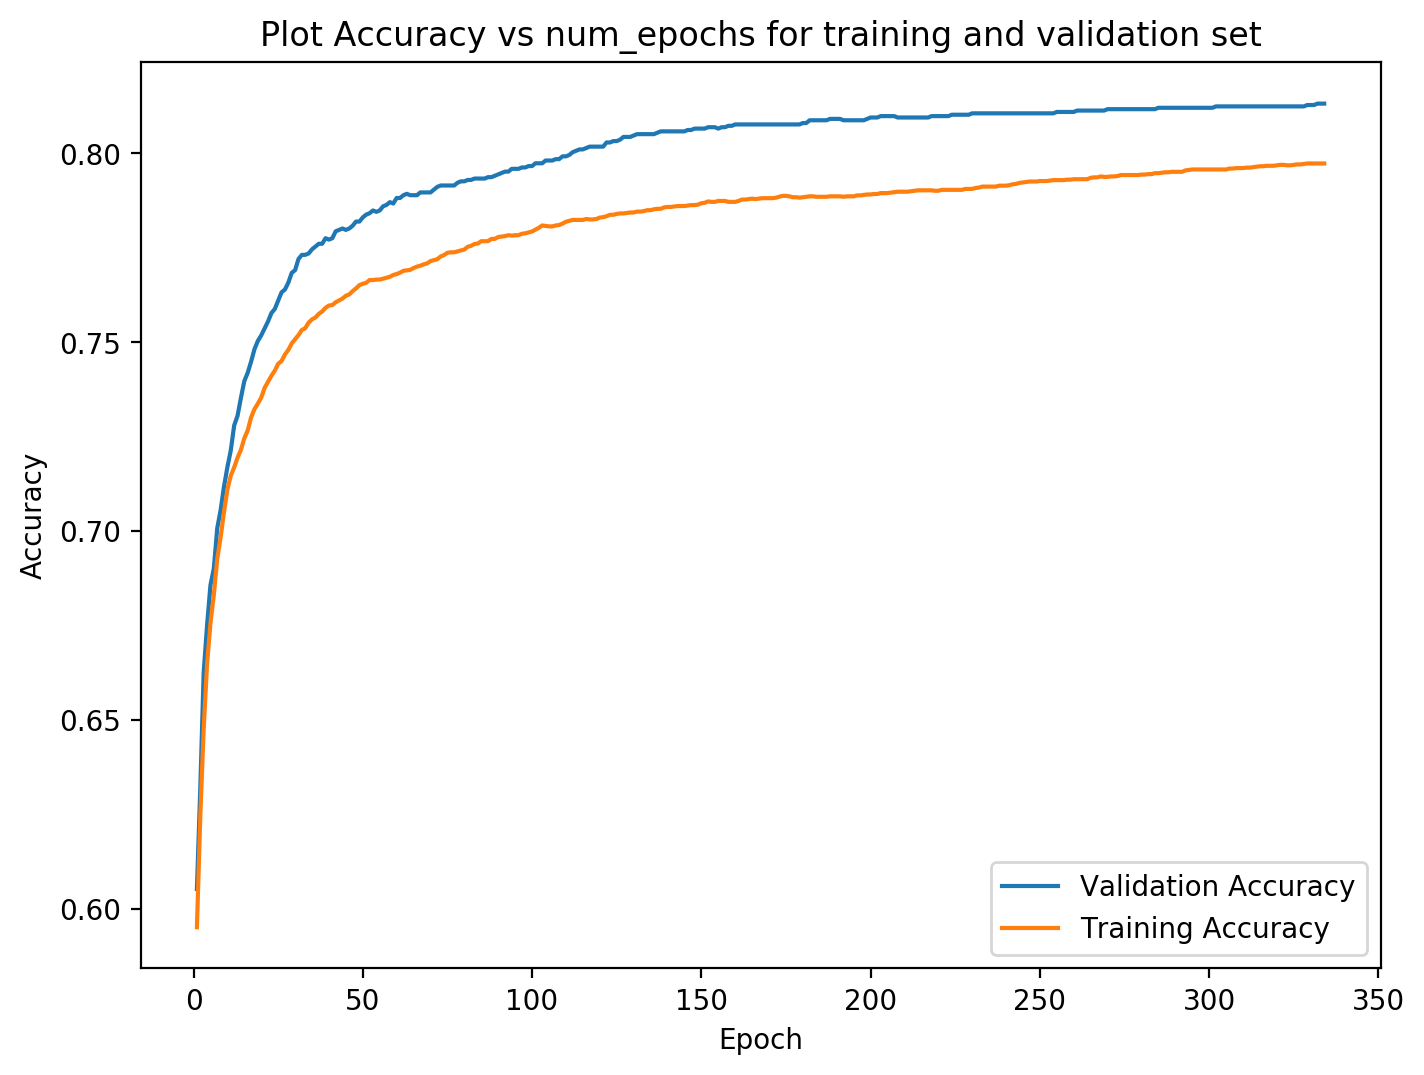

0.8131424375917768

In [676]:
# (b) Plot Accuracy vs num_epochs for both training and validation set on the same figure

# eta = 0.1
# eta1 = 1.0
# LR = LogisticRegression(eta,eta1,16,1000, 0.0001)
# theta, loss, validation_loss , training_accuracy , validation_accuracy = LR.fit(X_train,y_train, False, True, X_val, y_val)
# print("Number of epochs till termination: ", len(loss))
# epoch = np.arange(1,len(loss)+1,1)
plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
plt.plot(epoch, validation_accuracy, label = "Validation Accuracy")
plt.plot(epoch, training_accuracy, label = "Training Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Plot Accuracy vs num_epochs for training and validation set")
plt.legend()
plt.show()

accuracy_score(y_val, LR.predict(X_val))

### 4. ROC and Precision-Recall curves

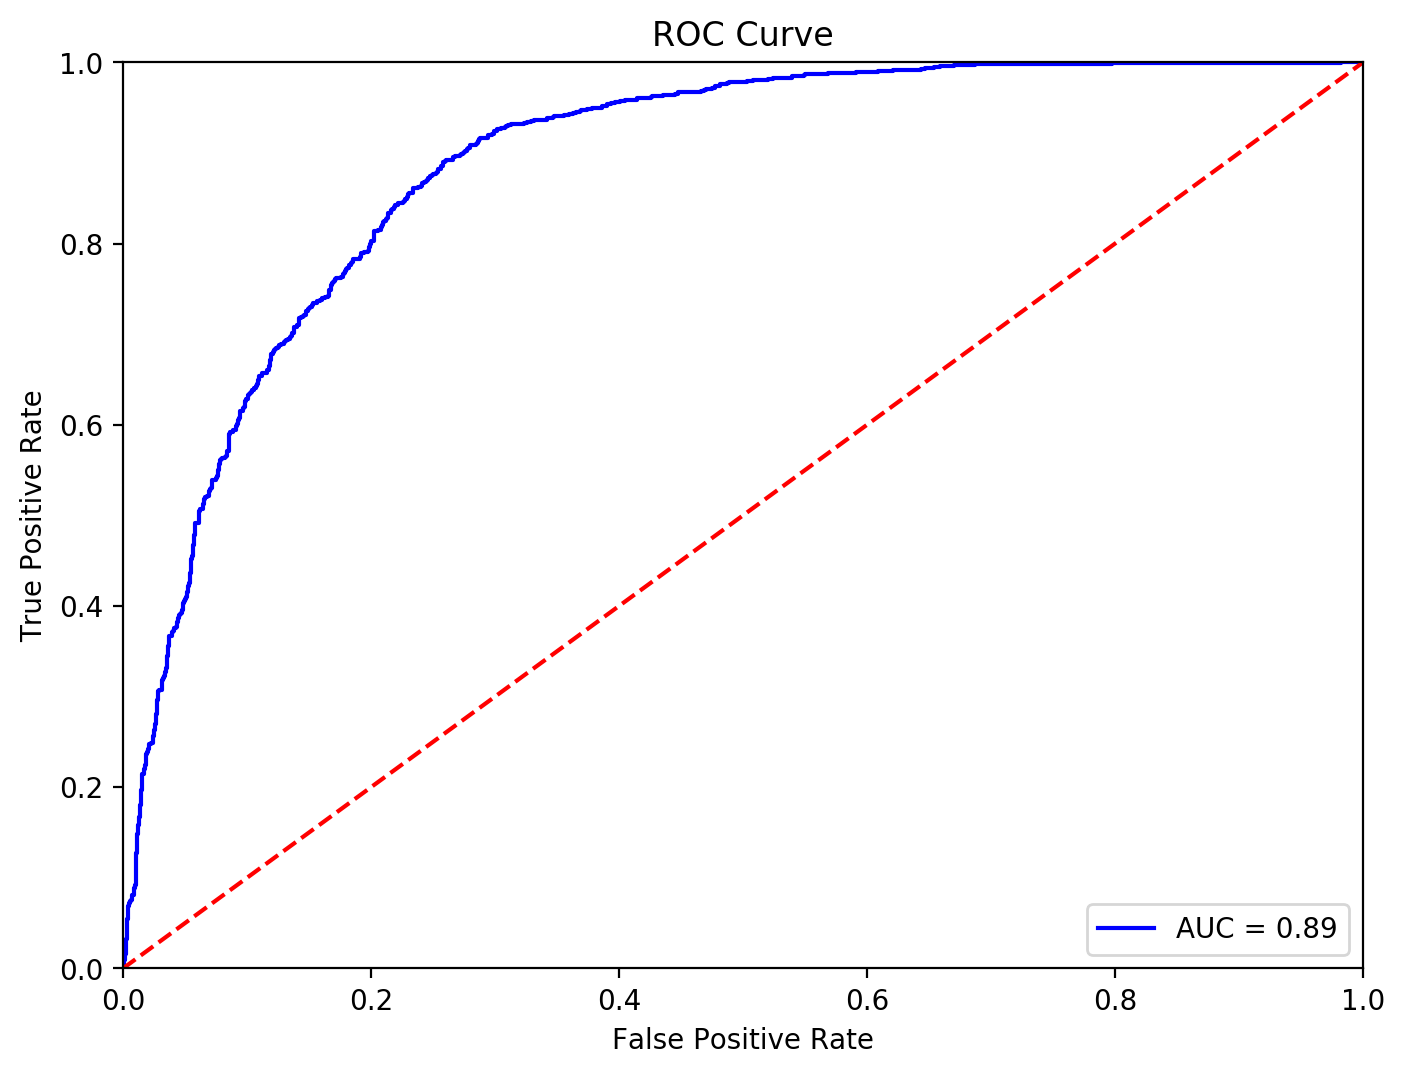

In [678]:
#(a) Plot ROC curve on validation data
eta = 0.1
eta1 = 1.0
# LR = LogisticRegression(eta,eta1,16,1000, 0.0001)
# theta, loss, validation_loss , training_accuracy , validation_accuracy = LR.fit(X_train,y_train, False, True, X_val, y_val)
# print("Number of epochs till termination: ", len(loss))
# epoch = np.arange(1,len(loss)+1,1)
# plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')

fpr, tpr, threshold = metrics.roc_curve(y_val, LR.predict_probs(X_val))
roc_auc = metrics.auc(fpr, tpr)
plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Area under curve = _0.89_

Text(0.5,1,'2-class Precision-Recall curve: AP=0.86')

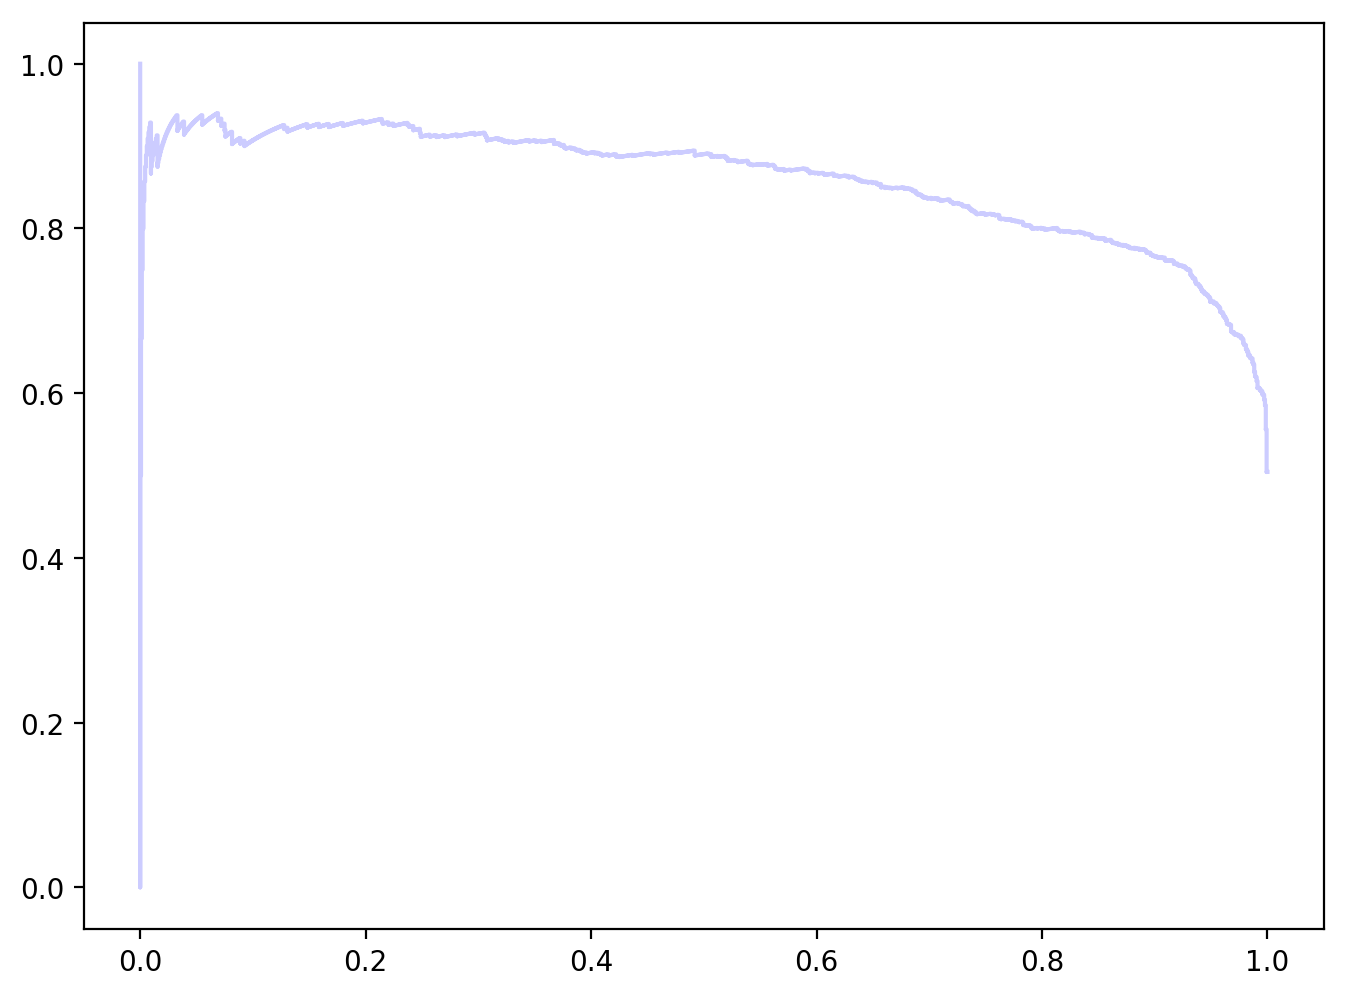

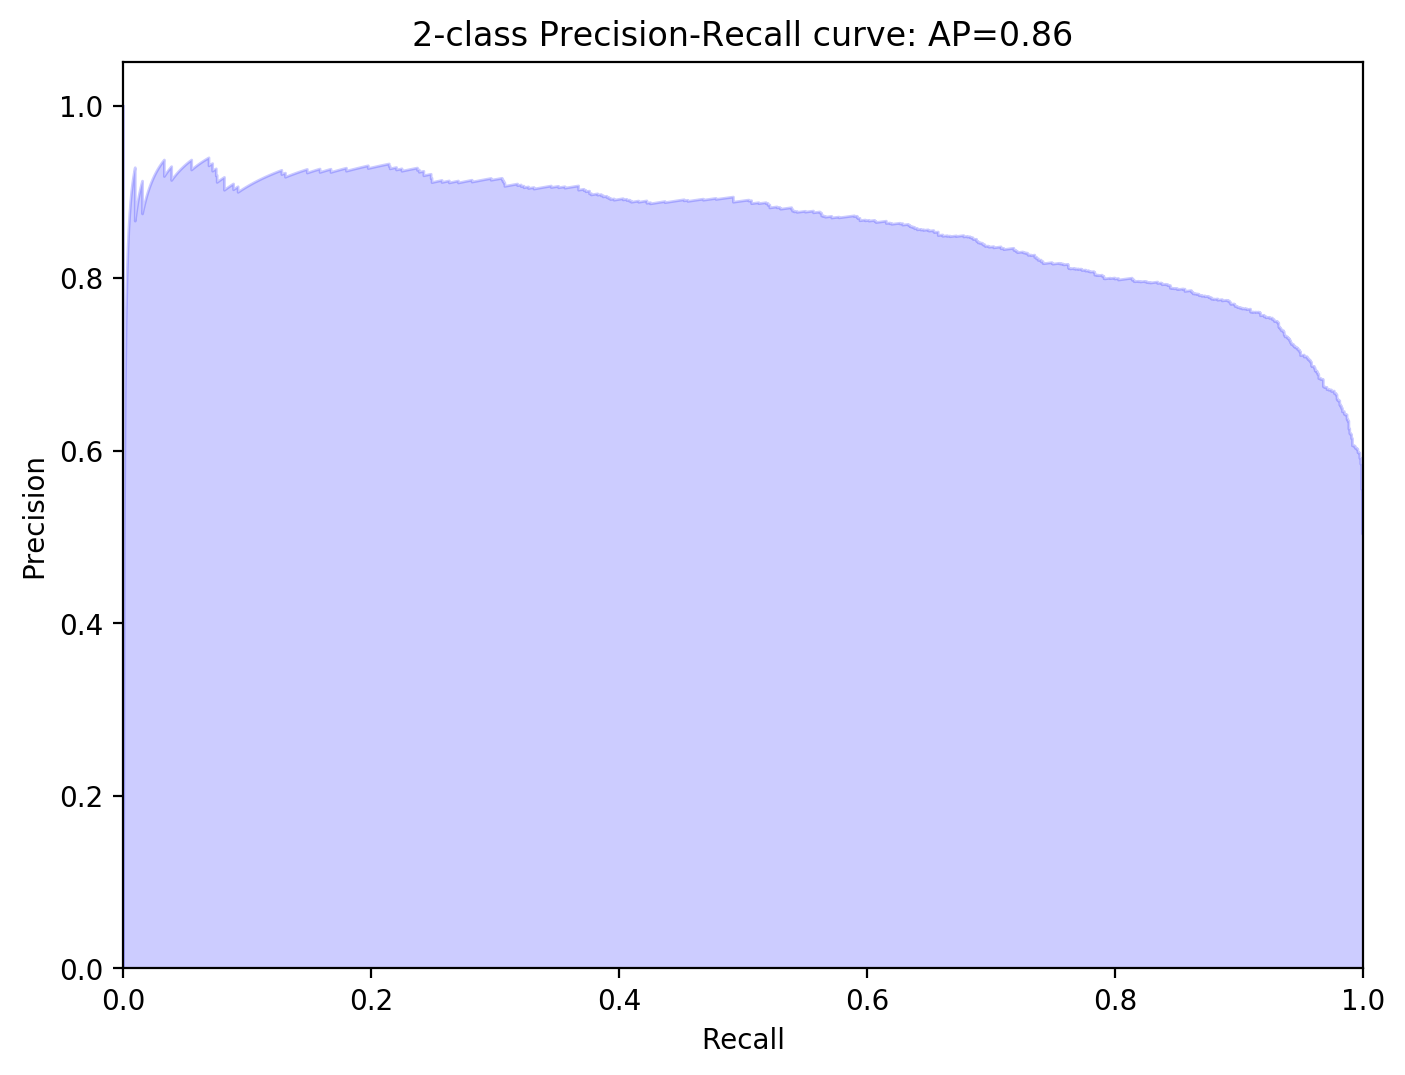

In [679]:
#(a) Plot Precision-Recall curve on validation data

average_precision = average_precision_score(y_val, LR.predict_probs(X_val))
precision, recall, thresholds = precision_recall_curve(y_val, LR.predict_probs(X_val))
plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [ ]:
Average Precision = _0.86_

## Question 2.4

### 1. Submission

In [571]:
import pandas as pd
def submission(y_pred):
    """
    generate the submission.csv for kaggle
    input args:
        y_pred: 5542x1 array or list contains 5542 elements
        
    """
    save_file = pd.DataFrame(columns=["Id","Class"])
    id = np.array([idx for idx in range(5542)])
    save_file["Id"] = id
    save_file["Class"]= y_pred
    save_file.to_csv("submission.csv",index=0)       

#### Generate the submission.csv

In [673]:
# code goes here
LR = LogisticRegression()
LR.load_model("best_theta_temp")
xv = np.concatenate( (X_val, np.square(X_val)), axis=1 )
temp = accuracy_score(y_val, LR.predict(xv))
print(temp)
xt = np.concatenate( (X_test, np.square(X_test)), axis=1 )
barray = LR.predict(xt)
# print(barray)
final = np.asarray(barray, dtype = np.int32)
# print(final)
submission(final)

0.8997797356828194


Best obtained accuracy on Public Leader-board = 89.029%

In [633]:

eta = 10.0
eta1 = 0.001
best_acc = 0.0
LR = LogisticRegression(eta,eta1,16,1000, 0.00001)
new_x = np.concatenate((X_train, X_val), axis=0)
xv = np.concatenate( (X_val, np.square(X_val)), axis=1 )
new_x2 = np.concatenate( (new_x, np.square(new_x)), axis=1 )
new_y = np.concatenate((y_train, y_val), axis=0)
LR.load_model("best_theta_temp")
best_acc = accuracy_score(new_y, LR.predict(new_x2))
for i in range(10):
    theta = LR.fit(new_x2, new_y, False, True,  xv, y_val)
    temp = accuracy_score(new_y, LR.predict(new_x2))
    if temp > best_acc:
        best_acc = temp
        LR.save_model("best_theta_temp")
print(best_acc)

(1, 'Training Loss:', 0.2484852970432462, 'Training Accuracy', 0.8999449238112722, 'Validation Accuracy:', 0.8979441997063142, 'Validation Loss:', 0.24467618948105066)
(1, 'Training Loss:', 0.25081275215583, 'Training Accuracy', 0.8975582889664036, 'Validation Accuracy:', 0.894640234948605, 'Validation Loss:', 0.2464753765029321)
(1, 'Training Loss:', 0.25067290120841584, 'Training Accuracy', 0.8984762254451992, 'Validation Accuracy:', 0.8983113069016153, 'Validation Loss:', 0.24619754342840183)
(1, 'Training Loss:', 0.24867834151325352, 'Training Accuracy', 0.9015054158252249, 'Validation Accuracy:', 0.9005139500734214, 'Validation Loss:', 0.24713285225395556)
(2, 'Training Loss:', 0.25758187442687885, 'Training Accuracy', 0.8920506700936295, 'Validation Accuracy:', 0.8920704845814978, 'Validation Loss:', 0.2521324916059556)
(1, 'Training Loss:', 0.24920862578523462, 'Training Accuracy', 0.8979254635579218, 'Validation Accuracy:', 0.8953744493392071, 'Validation Loss:', 0.244637573294